## 1. Creating a text representation for your class

Let's start with the basics! The way to do this is to add a `__repr__` method to your class.

We'll start with a simple example: we'll create a `Molecule` class which takes a SMILES as input, and for the representation we'll just show a descriptive text with the SMILES.

In [1]:
class Molecule:
    def __init__(self, smiles):
        self.smiles = smiles

    def __repr__(self):
        return f'<Molecule SMILES="{self.smiles}">'

Molecule("CC(=O)NCCC1=CNc2c1cc(OC)cc2")

<Molecule SMILES="CC(=O)NCCC1=CNc2c1cc(OC)cc2">

## 2. Creating rich displays for your classes

Plain text is great if you're still using a fax machine, but Jupyter-notebooks support numerous "richer" output types: images (PNG, SVG, JPEG), HTML, LaTeX, MarkDown, and more!

The most straightforward way to use of of these is to implement a `_repr_<type>_` method for your class, you can get the list of supported formats [here](https://ipython.readthedocs.io/en/stable/config/integrating.html#id1).

We'll continue from the previous `Molecule` example, and for the representation we'll fetch the PNG image from PubChem and display it in a `_repr_png_` method.

In [2]:
import requests
from html import escape

class Molecule:
    def __init__(self, smiles):
        self.smiles = smiles

    def __repr__(self):
        return f'<Molecule SMILES="{self.smiles}">'

    def _repr_png_(self):
        smiles = escape(self.smiles)
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/PNG"
        query = requests.get(url)
        if query.ok:
            png = query.content
            return png

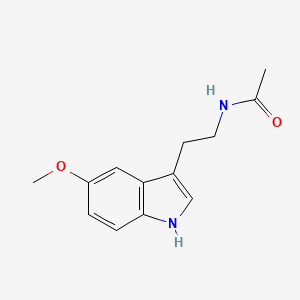

In [3]:
Molecule("CC(=O)NCCC1=CNc2c1cc(OC)cc2")

The good thing is that if the `_repr_png_` method is called but doesn't return any value (because the molecule could not be found in PubChem for example), it falls back to using the `__repr__` method.

In [4]:
Molecule("C"*333)

<Molecule SMILES="CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC">

This way you can decide wether or not to use the rich display for a molecule based on some other factors like the number of heavy atoms for example, and fall back to text for very large ones that wouldn't produce a readable image.

## 3. Rich displays for built-in types

Okay that's great, but what about built-in types? Can I just add a rich display method to `list` or `str`?

Well... not with the previous methodology, Python won't let you mess around with built-in types methods:

>TypeError: can't set attributes of built-in/extension type 'list'

But there's an alternative way of registering rich displays for any class or build-in type.

In this example, we will register a new rich display for `list` using the `text/markdown` format:

In [5]:
example = [
    "Never gonna give you up",
    "Never gonna let you down",
    "Never gonna run around and desert you"
]

example

['Never gonna give you up',
 'Never gonna let you down',
 'Never gonna run around and desert you']

In [6]:
def markdown_stylish_bullet_point(items):
    """Creates a bullet point MarkDown string out of a list of strings"""
    return "\n".join(f"- ***{item}***" for item in items)

(get_ipython()
 .display_formatter.formatters['text/markdown']
 .for_type(list, markdown_stylish_bullet_point))

example

- ***Never gonna give you up***
- ***Never gonna let you down***
- ***Never gonna run around and desert you***

Now you can use something similar for other builtins like `str`, `int` and others.

To get the list of available output formats using this method:

In [7]:
list(get_ipython().display_formatter.formatters.keys())

- ***text/plain***
- ***text/html***
- ***text/markdown***
- ***image/svg+xml***
- ***image/png***
- ***application/pdf***
- ***image/jpeg***
- ***text/latex***
- ***application/json***
- ***application/javascript***

Note that this won't affect calls to `print(...)` or `__repr__()`, it will only be active when you explicitely call `IPython.display.display` on the object, or when the object is the last instruction of a cell.

But what practically useful things can you do with this?

You can already create a function to draw the molecule corresponding to a SMILES, or a grid of molecules, and so on, so why bother? Well... I'll admit, this is mostly usefull out of... lazyness!

Ever been too lazy to type `Chem.MolFromSmiles(...)` to visualize what a molecule looks like?

Here's how to automatically display strings that could correspond to a SMILES as molecules:

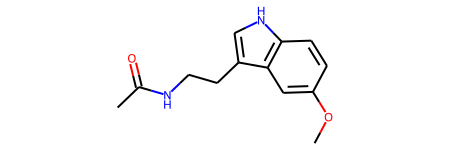

In [8]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger

IPythonConsole.ipython_useSVG = True

SMILES_CHARS = "AaBbCcDdEeFfGgHhIiKkLlMmNnOoPpRrSsTtUuVvWXYyZ0123456789()[].-=#$:/\\+-@"

def smiles_to_svg(smiles):
    if all(char in SMILES_CHARS for char in smiles):
        RDLogger.DisableLog("rdApp.*")
        try:
            mol = Chem.MolFromSmiles(smiles)
            svg = IPythonConsole._toSVG(mol)
        except Exception:
            svg = None
        RDLogger.EnableLog("rdApp.*")
        return svg

(get_ipython()
 .display_formatter.formatters['image/svg+xml']
 .for_type(str, smiles_to_svg))

"CC(=O)NCCC1=CNc2c1cc(OC)cc2"

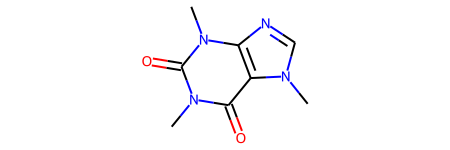

In [9]:
"CN1C=NC2=C1C(=O)N(C(=O)N2C)C"

In [10]:
"a normal string"

'a normal string'

The only ambiguous case that could work both as a word (kind of) and a valid SMILES that I could think of:

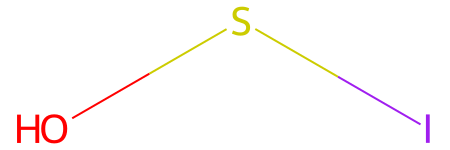

In [11]:
"ISO"

Now you might say

>"But wait Cedric, I have to type all that boilerplate code out of lazyness? That doesn't make any sense!"

And you'd be right! Now here comes the most usefull part of this blog post:

To run this code (or literally any code) everytime you open a notebook or IPython shell, you can create an **IPython startup file**.

Start by creating a default profile by typing this command in your bash shell: `ipython profile create`

You should now have a `~/.ipython/profile_default` folder.

Then you just need to add a file ending in `.py` in `~/.ipython/profile_default/startup/` with whatever code you need. This could be the above snippets, but also importing libraries that you use a lot, or setting up some defaults such as
```python
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
```